In [1]:
import numpy as np
np.random.seed(1337) 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer
from keras.models import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, LeakyReLU, Flatten, Dropout
from keras_self_attention import SeqSelfAttention
from keras.utils import custom_object_scope
from keras.callbacks import History, ModelCheckpoint
from keras import backend as K
from keras import metrics, regularizers
from keras.optimizers import Adam, Adagrad, Adadelta, RMSprop
from sklearn.metrics import confusion_matrix
import keras.regularizers
import keras
import glob
import os
import itertools
import fnmatch

In [2]:
os.chdir('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/PDF-Cluster-Prediction/all_data')
files_calc = glob.glob('*.dat')
files_exp = glob.glob('*processed.gr')

In [3]:
raw_data_points = []

with open('labels.txt', 'w') as labels:
    for f in files_calc:
        df = pd.read_csv(f, usecols=[1], skiprows=201, header=None, delim_whitespace=True, skipfooter=0, engine='python')
        raw_data_points.append(df.values.ravel())
        labels.write(f[0])
        labels.write('\n')
    for f in files_exp:
        df = pd.read_csv(f, usecols=[1], skiprows=1, header=None, delim_whitespace=True, skipfooter=1, engine='python')
        raw_data_points.append(df.values.ravel())
        labels.write(f[0])
        labels.write('\n')
        
raw_data_points = np.array(raw_data_points)

# Load the labels
labels = pd.read_csv("labels.txt", header=None)
one_hot_labels = pd.get_dummies(labels[0])
labels = one_hot_labels.values

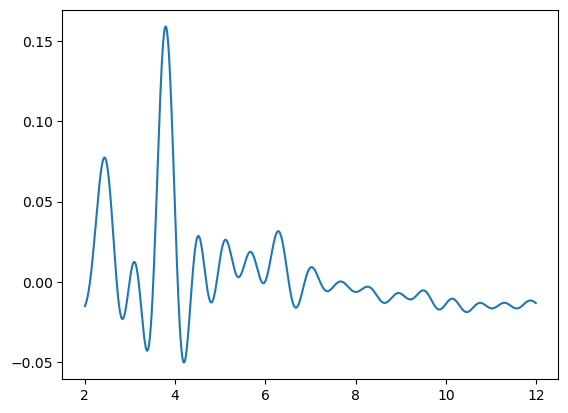

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# Preprocessing
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler =MaxAbsScaler()
#data_points = scaler.fit_transform(data_points)
normalize = Normalizer()
data_points = normalize.fit_transform(raw_data_points)
fig, ax = plt.subplots()
ax.plot(np.arange(len(data_points[43,:]))/100+2, data_points[43,:])

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_points, labels, test_size=0.2, random_state=42)

In [6]:
# Tuning of the model

model = Sequential()
# Add the convolutional layers
model.add(Conv1D(filters=32, kernel_size=256, activation='relu', input_shape=(1000,1), use_bias=False)) # 256, 32
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) # 2
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=16, activation='relu')) # 64, 32
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2)) # 2
model.add(Dropout(0.5))

model.add(SeqSelfAttention(attention_width=16, attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL)) # 16

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(units=128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))) # 128 0.01
model.add(Dropout(0.5))
model.add(Dense(units=8, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))) # 10 0.01

# Compile the model
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 745, 32)           8192      
                                                                 
 batch_normalization (BatchN  (None, 745, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 372, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 372, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 357, 32)           16416     
                                                                 
 dropout_1 (Dropout)         (None, 357, 32)           0

In [7]:
# Train the model
num_epochs = 700

checkpoint = ModelCheckpoint("onehot.hdf5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

seqModel = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/700


2023-02-09 14:17:10.545726: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/4 [=====================>........] - ETA: 0s - loss: 4.7105 - accuracy: 0.2708
Epoch 1: val_accuracy improved from -inf to 0.32000, saving model to onehot.hdf5
4/4 [==============================] - 1s 98ms/step - loss: 4.6913 - accuracy: 0.2755 - val_loss: 4.6802 - val_accuracy: 0.3200
Epoch 2/700
4/4 [==============================] - ETA: 0s - loss: 4.3377 - accuracy: 0.4286
Epoch 2: val_accuracy did not improve from 0.32000
4/4 [==============================] - 0s 45ms/step - loss: 4.3377 - accuracy: 0.4286 - val_loss: 4.6443 - val_accuracy: 0.3200
Epoch 3/700
3/4 [=====================>........] - ETA: 0s - loss: 4.3813 - accuracy: 0.4062
Epoch 3: val_accuracy did not improve from 0.32000
4/4 [==============================] - 0s 41ms/step - loss: 4.3782 - accuracy: 0.4082 - val_loss: 4.6158 - val_accuracy: 0.3200
Epoch 4/700
3/4 [=====================>........] - ETA: 0s - loss: 4.2435 - accuracy: 0.4271
Epoch 4: val_accuracy did not improve from 0.32000
4/4 [=================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


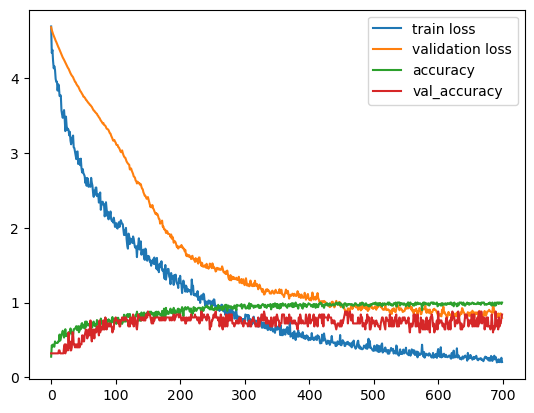

In [8]:
print(seqModel.history.keys())
xc         = range(num_epochs)

plt.plot(xc, seqModel.history['loss'], label='train loss')
plt.plot(xc, seqModel.history['val_loss'], label='validation loss')
plt.plot(xc, seqModel.history['accuracy'], label='accuracy')
plt.plot(xc, seqModel.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [9]:
with custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    load_model = keras.models.load_model('onehot.hdf5')

In [10]:
load_model.evaluate(X_train, y_train)
y_test_ordinal = np.argmax(y_test, axis=1)
y_pred_prob = load_model.predict(X_test)
y_pred_ordinal = np.argmax(y_pred_prob, axis=1)
confusion = confusion_matrix(y_test_ordinal, y_pred_ordinal)

1/1 [==============================] - 0s 105ms/step


Confusion matrix, without normalization
[[1 0 0 0 0 0]
 [0 5 0 0 0 0]
 [1 1 6 0 0 0]
 [0 0 1 2 0 0]
 [0 0 0 0 6 0]
 [0 0 0 0 0 2]]


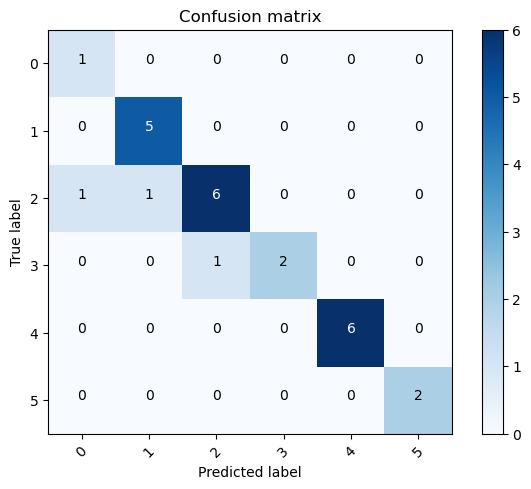

In [11]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion, classes = np.unique(y_test_ordinal), title='Confusion matrix', normalize=False)
plt.show()